
__Project Name:__ Churn Prediction - Die Zeit

__Team:__ Carlotta Ulm, Silas Mederer, Jonas Bechthold

__Date:__ 2020-10-26 to 2020-11-27

__Description:__ This notebook contains customer churn and the error analysis (False Negative) of the best voting and Stacking classifier presented in the [ML Notebook](https://github.com/jb-ds2020/nf-ds3-capstone-churn-prevention/blob/main/ML-Capstone_Zeit.ipynb).


# Imports and Data

In [48]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import math

# visualization
import seaborn as sns
sns.set(style="white")  
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingCVClassifier 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# feature selection
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

#Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Imbalanced Learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# random state
random_state = 100
pd.set_option('display.max_columns', None)

# Variables for plot sizes
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=14)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=14)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=14)    # legend fontsize
matplotlib.rc('figure', titlesize=20)

## Loading the top 51 features data from the dataframe and split dataset

In [2]:
# new feature dataframe
df_importance = pd.read_csv('data/df_clean_engineered_all.csv')

In [3]:
y = df_importance['churn'] 
df_importance = pd.get_dummies(df_importance, columns = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name','zahlung_weg_name', 
                                                         'plz_1', 'plz_2', 'land_iso_code', 'anrede','titel'], drop_first = True)

In [4]:
important_features_combined_dropping = ['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_halbjährlich',
 'rechnungsmonat',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'objekt_name_ZEIT Digital',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_3m',
 'anrede_Frau',
 'aboform_name_Geschenkabo',
 'unsubscribed_anzahl_1m',
 'studentenabo',
 'received_anzahl_bestandskunden_6m',
 'openrate_produktnews_3m',
 'opened_anzahl_bestandskunden_6m',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'nl_opened_1m',
 'kanal_andere',
 'kanal_B2B',
 'clicked_anzahl_6m',
 'che_reg',
 'MONTH_DELTA_nl_min',
 'zon_zp_red',
 'zahlung_rhythmus_name_vierteljährlich',
 'unsubscribed_anzahl_hamburg_1m',
 'unsubscribed_anzahl_6m',
 'sum_zon',
 'sum_reg',
 'shop_kauf',
 'plz_2_10',
 'plz_1_7',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_1m',
 'openrate_3m',
 'openrate_1m',
 'nl_unsubscribed_6m',
 'nl_fdz_organisch',
 'metropole',
 'cnt_abo_magazin',
 'cnt_abo_diezeit_digital',
 'cnt_abo',
 'clicked_anzahl_bestandskunden_3m',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

In [5]:
X = df_importance[important_features_combined_dropping]

## Train-Test Split

In [6]:
# devide features
categoric_features = list(X.columns[X.dtypes==object])

numeric_features = list(X.columns[X.dtypes != object])

# split train and test set
df, df_test = train_test_split(df_importance, random_state=1, stratify=y)

In [7]:
X_train = df[important_features_combined_dropping]
y_train = df['churn']
X_test = df_test[important_features_combined_dropping]
y_test = df_test['churn']

## Preprocessor

In [8]:
#create preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer_num', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)
    ])

In [9]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Undersampling

In [12]:
print('Undersampling')
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)

Undersampling


In [13]:
X_train.shape

(83970, 51)

In [14]:
X_test.shape

(46165, 51)

# Who churns?
This chapter focuses to identify which customer churn and how they differ from all customers. The goal is to obtain a customer profile of the customers who are churning.

## Create new df
Therefore we create a new Dataframe containing all customers who churned from the original Datafram with all features. 

In [85]:
df_churn = df_importance.copy()

In [93]:
churn = (df_churn['churn'] == 1)
df_churn = df_churn[churn]

In [94]:
df_churn['anrede_Frau'].value_counts()/df_churn.shape[0]

0    0.529725
1    0.470275
Name: anrede_Frau, dtype: float64

In [95]:
df_churn['studentenabo'].value_counts()/df_churn.shape[0]

0    0.840622
1    0.159378
Name: studentenabo, dtype: float64

In [96]:
df_churn['objekt_name_DIE ZEIT - CHRIST & WELT'].value_counts()/df_churn.shape[0]

0    0.984137
1    0.015863
Name: objekt_name_DIE ZEIT - CHRIST & WELT, dtype: float64

In [97]:
df_churn['objekt_name_ZEIT Digital'].value_counts()/df_churn.shape[0]

0    0.66438
1    0.33562
Name: objekt_name_ZEIT Digital, dtype: float64

In [100]:
print(df_churn['zahlung_weg_name_Kreditkarte'].value_counts()/df_churn.shape[0])
print(df_churn['zahlung_weg_name_PayPal'].value_counts()/df_churn.shape[0])
print(df_churn['zahlung_weg_name_Rechnung'].value_counts()/df_churn.shape[0])

0    0.986406
1    0.013594
Name: zahlung_weg_name_Kreditkarte, dtype: float64
0    0.988282
1    0.011718
Name: zahlung_weg_name_PayPal, dtype: float64
1    0.609253
0    0.390747
Name: zahlung_weg_name_Rechnung, dtype: float64


In [99]:
print(df_churn['aboform_name_Geschenkabo'].value_counts()/df_churn.shape[0])
print(df_churn['aboform_name_Negative Option'].value_counts()/df_churn.shape[0])
print(df_churn['aboform_name_Probeabo'].value_counts()/df_churn.shape[0])
print(df_churn['aboform_name_Prämienabo'].value_counts()/df_churn.shape[0])

0    0.952412
1    0.047588
Name: aboform_name_Geschenkabo, dtype: float64
0    0.581583
1    0.418417
Name: aboform_name_Negative Option, dtype: float64
0    0.886388
1    0.113612
Name: aboform_name_Probeabo, dtype: float64
0    0.989139
1    0.010861
Name: aboform_name_Prämienabo, dtype: float64


# StackingCVClassifier - Metaclassifier Logistic Regression
This chapter focuses to examine those customers the Stacking Classifier missed.

In [15]:
# recall = 0.770
classifier1 = RandomForestClassifier(n_estimators = 380, criterion = "entropy", max_depth = 35,
                                     max_features = "auto", min_samples_leaf = 1,
                                     min_samples_split = 4, n_jobs = -1, bootstrap = True, random_state = random_state)

# recall = 0.692
classifier2 = LogisticRegression(solver='liblinear',penalty='l2',C=10,n_jobs=-1)

# precision = 0.518
classifier3 = KNeighborsClassifier(n_neighbors = 30,weights='distance',p=1,metric='manhattan',n_jobs=-1)

# precision = 0.609
classifier4 = RandomForestClassifier(n_estimators = 2000, criterion = "entropy", max_depth = None,
                                     max_features = "sqrt", min_samples_leaf = 2,
                                     min_samples_split = 5, n_jobs = -1, bootstrap = False, random_state = random_state)

# recall=  0.728
classifier5 = XGBClassifier(eta = 0.2, gamma = 0, max_depth = 9, min_child_weight = 4, sampling_method='gradient_based', subsample=1,
                            tree_method = 'hist', validate_parameter = True, random_state=random_state, n_jobs=-1)

# Initializing the StackingCV classifier without the logreg classifier
sclf = StackingCVClassifier(classifiers = [classifier1, classifier3, classifier4, classifier5],
                            shuffle = False,
                            use_probas = True,
                            cv = 3,
                            meta_classifier = LogisticRegression(n_jobs=-1),
                            n_jobs=-1,
                            random_state = random_state,
                            verbose=2)

# store classifiers in dictionary
classifiers = {"RF_recall": classifier1,
               "LogReg_recall": classifier2,
               "RF_precision": classifier4,
               "XGB_recall": classifier5,
               "Stack": sclf}

# train all classifiers
for key in classifiers:
    # get classifier
    classifier = classifiers[key]
    
    # fit classifier
    print('Fit classififer: ',key)
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier
    
# Get results
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    print('Make Predictions')
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    
    # Save results in pandas dataframe
    results[f"{key}"] = y_pred

# Add the test set to the results object
results["Target"] = y_test.values

# prediction and results
y_stack_predicted = sclf.predict(X_test)

print('Confusion Matrix Test')
print(confusion_matrix(y_test, y_stack_predicted))

print('Classification Report Test')
print(classification_report(y_test, y_stack_predicted))

print(f"Recall: {recall_score(y_test, y_stack_predicted):.3f}")

print(f"Precision: {precision_score(y_test, y_stack_predicted):.3f}")

print(f"Accuracy: {accuracy_score(y_test, y_stack_predicted):.3f}")

Fit classififer:  RF_recall
Fit classififer:  LogReg_recall
Fit classififer:  RF_precision
Fit classififer:  XGB_recall
Fit classififer:  Stack
Fitting 4 classifiers...
Fitting classifier1: randomforestclassifier (1/4)
RandomForestClassifier(criterion='entropy', max_depth=35, min_samples_split=4,
                       n_estimators=380, n_jobs=-1, random_state=100)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting classifier2: kneighborsclassifier (2/4)
KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=30, p=1,
                     weights='distance')


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting classifier3: randomforestclassifier (3/4)
RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=2000, n_jobs=-1,
                       random_state=100)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting classifier4: xgbclassifier (4/4)
XGBClassifier(eta=0.2, max_depth=9, min_child_weight=4, n_jobs=-1,
              random_state=100, sampling_method='gradient_based',
              tree_method='hist', validate_parameter=True)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Make Predictions
Make Predictions
Make Predictions
Make Predictions
Make Predictions
Confusion Matrix Test
[[25172  6998]
 [ 3235 10760]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     32170
           1       0.61      0.77      0.68     13995

    accuracy                           0.78     46165
   macro avg       0.75      0.78      0.75     46165
weighted avg       0.80      0.78      0.78     46165

Recall: 0.769
Precision: 0.606
Accuracy: 0.778


In [16]:
print(f"F1: {f1_score(y_test, y_stack_predicted):.3f}")

F1: 0.678


## Create new df
To be able to observe where the Model predicted wrong we are goin to have a look at the False negative values of the test data. <br>
The preddiction of the best Stacking Classifier is going to be added to a copy of the test dataset.

In [17]:
df_post = df_test.copy()

In [18]:
#Create new dataframe with the predicted churn
df2 = pd.DataFrame(y_stack_predicted, columns=['churn_pred'])

In [19]:
# add column of new data frames on df_post
df_post['churn_pred'] = df2['churn_pred'].values

In [20]:
df_post

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,plz_3,ort,metropole,shop_kauf,unterbrechung,email_am_kunden,...,plz_2_xx,land_iso_code_CH,land_iso_code_DE,land_iso_code_andere,anrede_Frau,anrede_Herr,anrede_unbekannt,titel_kein Titel,titel_sonstiger Titel,churn_pred
17293,2015.250000,56,0,0,145,Kleinmachnow,0,0,0,1.0,...,0,0,1,0,0,1,0,0,0,0
140745,2018.833333,14,0,0,694,Weinheim,0,1,0,1.0,...,0,0,1,0,0,1,0,1,0,0
33637,2016.000000,50,0,0,675,Worms,0,0,0,1.0,...,0,0,1,0,1,0,0,1,0,0
163048,2018.916667,18,0,0,xx,Luxembourg,0,0,0,1.0,...,1,0,0,1,0,1,0,1,0,0
163616,2018.583333,22,0,0,406,Erkrath,0,0,0,1.0,...,0,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27608,2014.000000,75,0,0,xx,Wien,1,0,0,1.0,...,1,0,0,0,1,0,0,1,0,0
69011,2017.083333,31,0,0,806,München,1,0,0,1.0,...,0,0,1,0,1,0,0,1,0,0
55757,2016.000000,53,0,0,343,Espenau,0,0,0,1.0,...,0,0,1,0,1,0,0,1,0,0
12672,2013.833333,76,0,0,104,Berlin,1,0,0,1.0,...,0,0,1,0,1,0,0,1,0,0


## False Negatives - on test data 
A __false negative__ is an outcome where the model incorrectly predicts the negative class. In our case the model predicted the customers to not churn, but in reality they did churn. Therefore, the churn prevention activities would miss those worng predicted customers. 

Actual: 1 <br>
Pred: False

In [21]:
FN = (df_post['churn'] == 1) & (df_post['churn_pred'] == False)
df_FN = df_post[FN]

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,plz_3,ort,metropole,shop_kauf,unterbrechung,email_am_kunden,...,plz_2_xx,land_iso_code_CH,land_iso_code_DE,land_iso_code_andere,anrede_Frau,anrede_Herr,anrede_unbekannt,titel_kein Titel,titel_sonstiger Titel,churn_pred
40292,2015.916667,47,0,0,674,Neustadt,0,0,0,1.0,...,0,0,1,0,1,0,0,1,0,0
5069,2014.083333,75,0,0,701,Stuttgart,1,0,1,1.0,...,0,0,1,0,1,0,0,1,0,0
49968,2016.500000,40,0,0,258,Breklum,0,0,0,1.0,...,0,0,1,0,0,1,0,1,0,0
89787,2018.666667,14,0,0,243,Plön,0,4,0,1.0,...,0,0,1,0,0,1,0,1,0,0
136769,2018.666667,12,0,0,603,Frankfurt,0,0,0,1.0,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69372,2017.000000,34,0,0,011,Dresden,1,0,0,0.0,...,0,0,1,0,0,1,0,1,0,0
154085,2018.416667,13,0,0,xx,Salzburg,0,0,0,1.0,...,1,0,0,0,1,0,0,1,0,0
155609,2019.333333,11,0,1,786,Rottweil,0,0,0,1.0,...,0,0,1,0,0,1,0,1,0,0
137661,2019.416667,7,0,0,720,Tübingen,0,0,0,1.0,...,0,0,1,0,1,0,0,1,0,0


In [50]:
df_FN

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,plz_3,ort,metropole,shop_kauf,unterbrechung,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz,cnt_abo,cnt_abo_diezeit,cnt_abo_diezeit_digital,cnt_abo_magazin,cnt_umwandlungsstatus2_dkey,abo_registrierung_min,nl_zeitbrief,nl_zeitshop,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,nl_opt_in_sum,boa_reg,che_reg,sit_reg,sso_reg,received_anzahl_1w,received_anzahl_1m,received_anzahl_3m,received_anzahl_6m,opened_anzahl_1w,opened_anzahl_1m,opened_anzahl_3m,openedanzahl_6m,clicked_anzahl_1w,clicked_anzahl_1m,clicked_anzahl_3m,clicked_anzahl_6m,unsubscribed_anzahl_1w,unsubscribed_anzahl_1m,unsubscribed_anzahl_3m,unsubscribed_anzahl_6m,openrate_1w,clickrate_1w,openrate_1m,clickrate_1m,openrate_3m,clickrate_3m,received_anzahl_bestandskunden_1w,received_anzahl_bestandskunden_1m,received_anzahl_bestandskunden_3m,received_anzahl_bestandskunden_6m,opened_anzahl_bestandskunden_1w,opened_anzahl_bestandskunden_1m,opened_anzahl_bestandskunden_3m,opened_anzahl_bestandskunden_6m,clicked_anzahl_bestandskunden_1w,clicked_anzahl_bestandskunden_1m,clicked_anzahl_bestandskunden_3m,clicked_anzahl_bestandskunden_6m,unsubscribed_anzahl_bestandskunden_1w,unsubscribed_anzahl_bestandskunden_1m,unsubscribed_anzahl_bestandskunden_3m,unsubscribed_anzahl_bestandskunden_6m,openrate_bestandskunden_1w,clickrate_bestandskunden_1w,openrate_bestandskunden_1m,clickrate_bestandskunden_1m,openrate_bestandskunden_3m,clickrate_bestandskunden_3m,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,opened_anzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,opened_anzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,received_anzahl_zeitbrief_1w,received_anzahl_zeitbrief_1m,received_anzahl_zeitbrief_3m,received_anzahl_zeitbrief_6m,opened_anzahl_zeitbrief_1w,opened_anzahl_zeitbrief_1m,opened_anzahl_zeitbrief_3m,opened_anzahl_zeitbrief_6m,clicked_anzahl_zeitbrief_1w,clicked_anzahl_zeitbrief_1m,clicked_anzahl_zeitbrief_3m,clicked_anzahl_zeitbrief_6m,unsubscribed_anzahl_zeitbrief_1w,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,kuendigungs_eingangs_datum,churn,date_x,sum_zon,sum_reg,nl_received_1w,nl_received_1m,nl_received_3m,nl_received_6m,nl_opened_1w,nl_opened_1m,nl_opened_3m,nl_opened_6m,nl_clicked_1w,nl_clicked_1m,nl_clicked_3m,nl_clicked_6m,nl_unsubscribed_1w,nl_unsubscribed_1m,nl_unsubscribed_3m,nl_unsubscribed_6m,MONTH_DELTA_abo_min,MONTH_DELTA_nl_min,kanal_B2B,kanal_E-Mailing,kanal_Eigenwerbung,kanal_Fremdwerbung,kanal_Mailings,kanal_SEA,kanal_Standwerbung,kanal_Telefonmarketing,kanal_andere,objekt_

In [27]:
df_FN['anrede_Frau'].value_counts()/df_FN.shape[0]

0    0.578053
1    0.421947
Name: anrede_Frau, dtype: float64

In [40]:
df_FN['studentenabo'].value_counts()/df_FN.shape[0]

0    0.924266
1    0.075734
Name: studentenabo, dtype: float64

In [41]:
df_FN['objekt_name_DIE ZEIT - CHRIST & WELT'].value_counts()/df_FN.shape[0]

0    0.970634
1    0.029366
Name: objekt_name_DIE ZEIT - CHRIST & WELT, dtype: float64

In [44]:
df_FN['objekt_name_ZEIT Digital'].value_counts()/df_FN.shape[0]

0    0.587944
1    0.412056
Name: objekt_name_ZEIT Digital, dtype: float64

In [52]:
print(df_FN['zahlung_weg_name_Kreditkarte'].value_counts()/df_FN.shape[0])
print(df_FN['zahlung_weg_name_PayPal'].value_counts()/df_FN.shape[0])
print(df_FN['zahlung_weg_name_Rechnung'].value_counts()/df_FN.shape[0])

0    0.976198
1    0.023802
Name: zahlung_weg_name_Kreditkarte, dtype: float64
0    0.988872
1    0.011128
Name: zahlung_weg_name_PayPal, dtype: float64
0    0.632148
1    0.367852
Name: zahlung_weg_name_Rechnung, dtype: float64


In [53]:
print(df_FN['aboform_name_Geschenkabo'].value_counts()/df_FN.shape[0])
print(df_FN['aboform_name_Negative Option'].value_counts()/df_FN.shape[0])
print(df_FN['aboform_name_Probeabo'].value_counts()/df_FN.shape[0])
print(df_FN['aboform_name_Prämienabo'].value_counts()/df_FN.shape[0])

0    0.958887
1    0.041113
Name: aboform_name_Geschenkabo, dtype: float64
0    0.706028
1    0.293972
Name: aboform_name_Negative Option, dtype: float64
0    0.84544
1    0.15456
Name: aboform_name_Probeabo, dtype: float64
0    0.984235
1    0.015765
Name: aboform_name_Prämienabo, dtype: float64


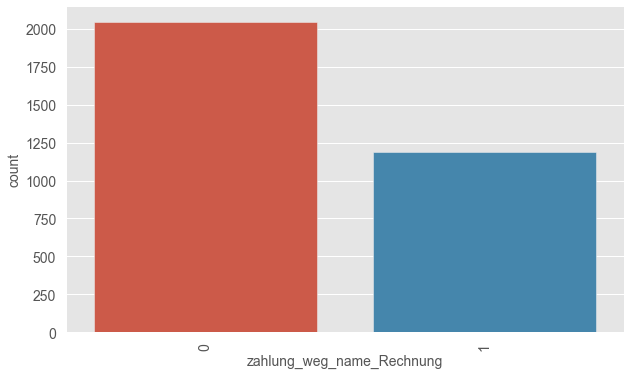

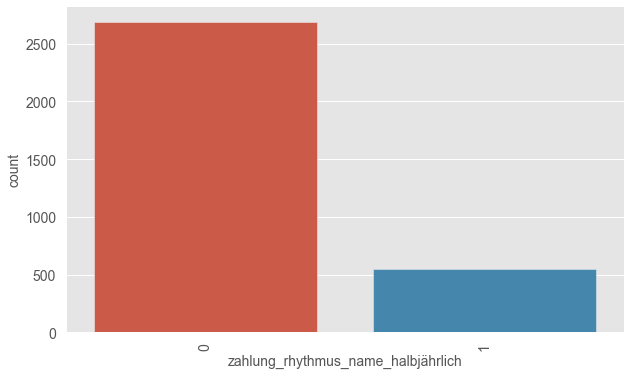

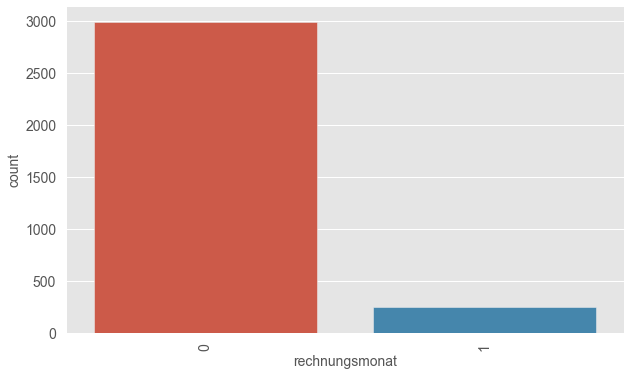

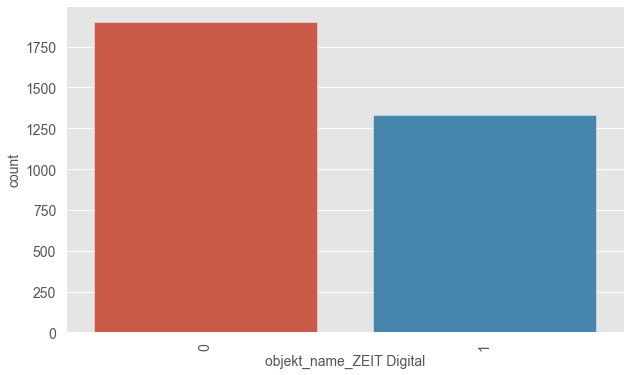

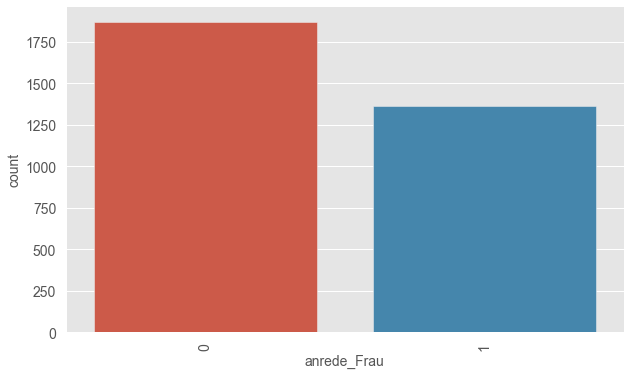

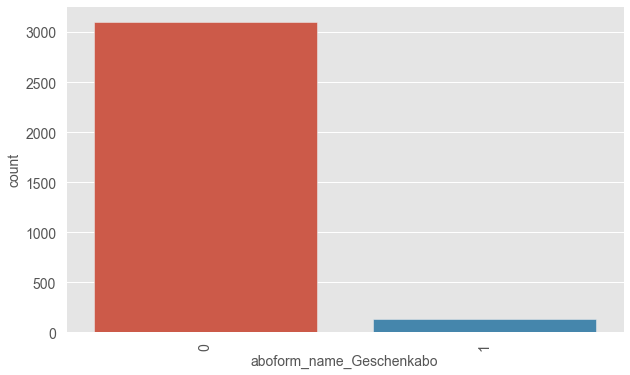

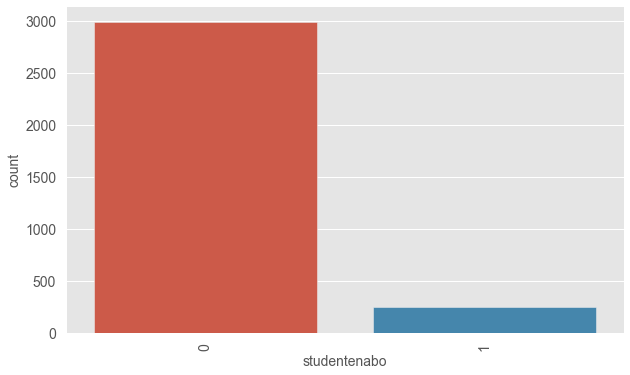

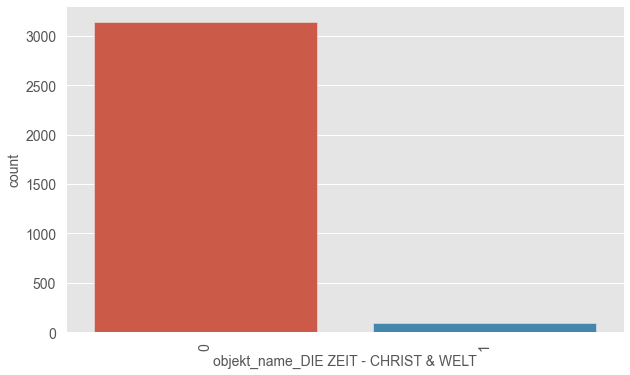

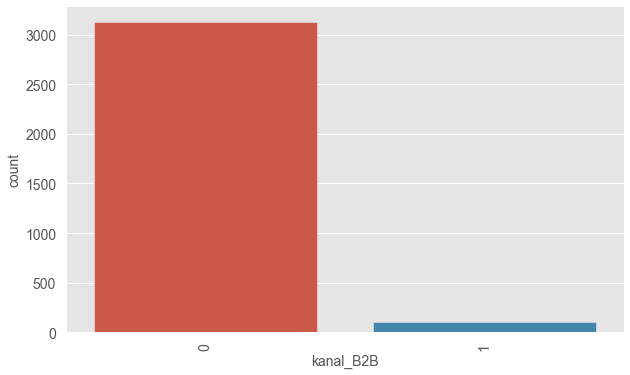

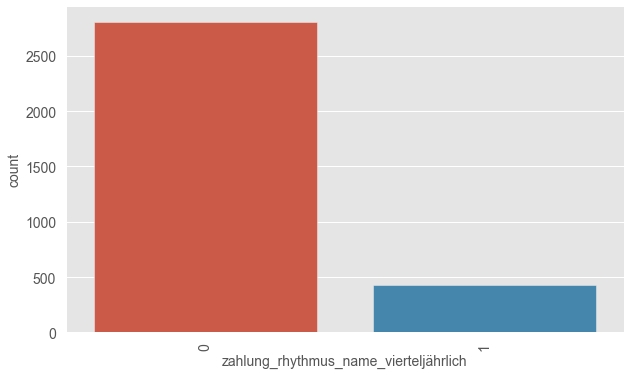

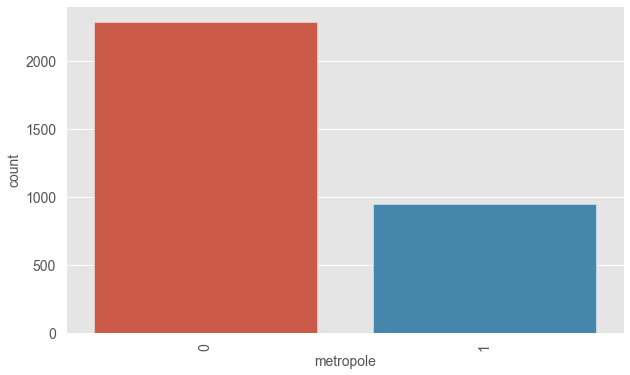

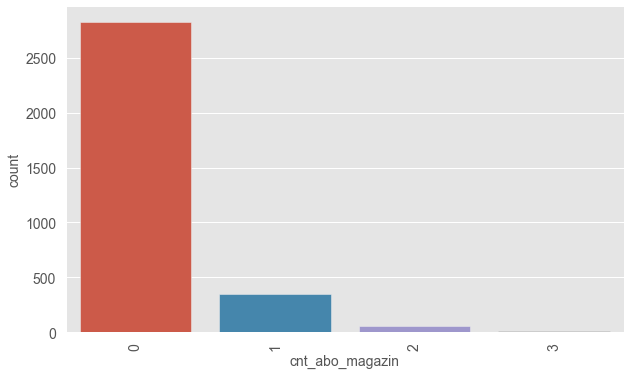

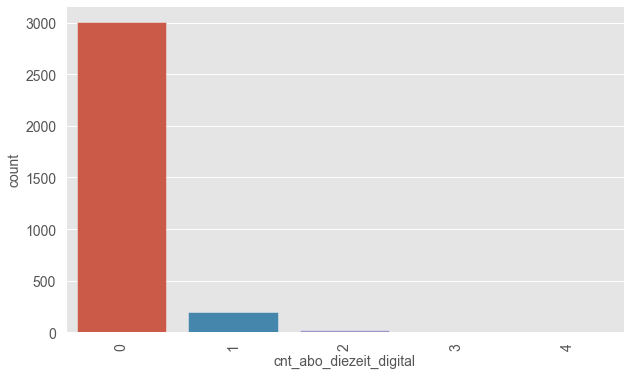

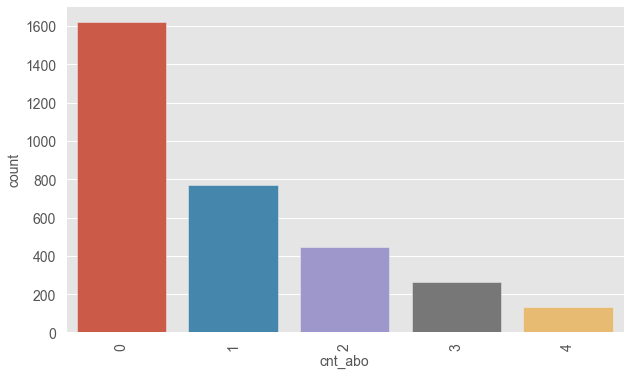

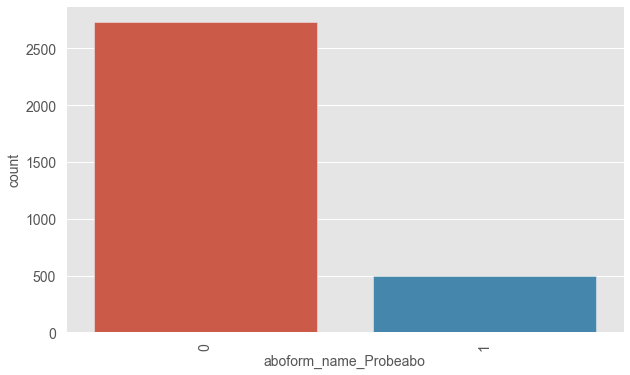

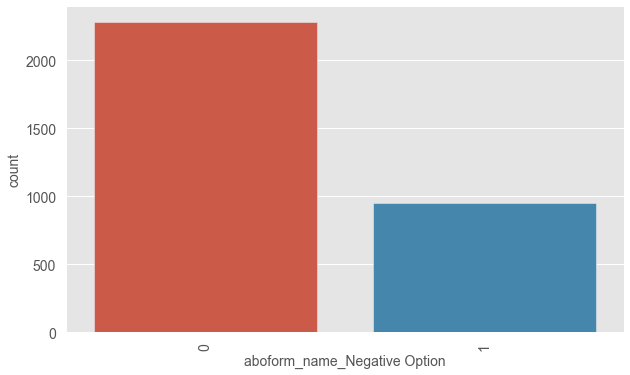

In [22]:
for i, f in enumerate(['zahlung_weg_name_Rechnung','zahlung_rhythmus_name_halbjährlich','rechnungsmonat', 'objekt_name_ZEIT Digital','anrede_Frau',
 'aboform_name_Geschenkabo','studentenabo','objekt_name_DIE ZEIT - CHRIST & WELT','kanal_B2B','zahlung_rhythmus_name_vierteljährlich',
 'metropole','cnt_abo_magazin', 'cnt_abo_diezeit_digital', 'cnt_abo','aboform_name_Probeabo', 'aboform_name_Negative Option']):
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=f, data=df_FN)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Voting Classifier - Soft Vote 5 Classifier
This chapter focuses to examine those customers the Voting Classifier missed.

In [54]:
# recall = 0.770
classifier1 = RandomForestClassifier(n_estimators = 380, criterion = "entropy", max_depth = 35,
                                     max_features = "auto", min_samples_leaf = 1,
                                     min_samples_split = 4, n_jobs = -1, bootstrap = True, random_state = random_state)

# recall = 0.692
classifier2 = LogisticRegression(solver='liblinear',penalty='l2',C=10,n_jobs=-1)


# Precision Optimization
# precision = 0.518
classifier3 = KNeighborsClassifier(n_neighbors = 30,weights='distance',p=1,metric='manhattan',n_jobs=-1)

# precision = 0.609
classifier4 = RandomForestClassifier(n_estimators = 2000, criterion = "entropy", max_depth = None,
                                     max_features = "sqrt", min_samples_leaf = 2,
                                     min_samples_split = 5, n_jobs = -1, bootstrap = False, random_state = random_state)

# recall=  0.728
classifier5 = XGBClassifier(eta = 0.2, gamma = 0, max_depth = 9, min_child_weight = 4, sampling_method='gradient_based', subsample=1,
                            tree_method = 'hist', validate_parameter = True, random_state=random_state, n_jobs=-1)



voting_clf_soft = VotingClassifier(estimators = [('RF_recall',classifier1), ('LogReg_recall',classifier2), ('KNN_precision',classifier3), ('RF_precision',classifier4), ('XGB_recall',classifier5)], voting = 'soft',verbose=True)
voting_clf_soft.fit(X_train,y_train)
y_voting_predicted_soft = voting_clf_soft.predict(X_test)
y_voting_predicted_soft_proba = voting_clf_soft.predict_proba(X_test)

print('Confusion Matrix Test')
print(confusion_matrix(y_test, y_voting_predicted_soft))

print('Classification Report Test')
print(classification_report(y_test, y_voting_predicted_soft))

print(f"Recall: {recall_score(y_test, y_voting_predicted_soft):.3f}")
print(f"Precision: {precision_score(y_test, y_voting_predicted_soft):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_voting_predicted_soft):.3f}")
print(f"F1: {f1_score(y_test, y_voting_predicted_soft):.3f}")

[Voting] ................ (1 of 5) Processing RF_recall, total=  27.8s
[Voting] ............ (2 of 5) Processing LogReg_recall, total=   0.7s
[Voting] ............ (3 of 5) Processing KNN_precision, total=   8.3s
[Voting] ............. (4 of 5) Processing RF_precision, total= 3.2min
[Voting] ............... (5 of 5) Processing XGB_recall, total=   4.8s
Confusion Matrix Test
[[24398  7772]
 [ 2982 11013]]
Classification Report Test
              precision    recall  f1-score   support

           0       0.89      0.76      0.82     32170
           1       0.59      0.79      0.67     13995

    accuracy                           0.77     46165
   macro avg       0.74      0.77      0.75     46165
weighted avg       0.80      0.77      0.77     46165

Recall: 0.787
Precision: 0.586
Accuracy: 0.767
F1: 0.672


## Create new df
To be able to observe where the Model predicted wrong we are goin to have a look at the False negative values of the test data. <br>
The preddiction of the best Voting Classifier is going to be added to a copy of the test dataset.

In [55]:
df_vot = df_test.copy()

In [56]:
#Create new dataframe with the predicted churn
df3 = pd.DataFrame(y_voting_predicted_soft, columns=['churn_pred'])

In [57]:
# add column of new data frame on df_vot
df_vot['churn_pred'] = df3['churn_pred'].values
df_vot

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,plz_3,ort,metropole,shop_kauf,unterbrechung,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz,cnt_abo,cnt_abo_diezeit,cnt_abo_diezeit_digital,cnt_abo_magazin,cnt_umwandlungsstatus2_dkey,abo_registrierung_min,nl_zeitbrief,nl_zeitshop,nl_zeitverlag_hamburg,nl_fdz_organisch,nl_blacklist_sum,nl_bounced_sum,nl_aktivitaet,nl_registrierung_min,nl_sperrliste_sum,nl_opt_in_sum,boa_reg,che_reg,sit_reg,sso_reg,received_anzahl_1w,received_anzahl_1m,received_anzahl_3m,received_anzahl_6m,opened_anzahl_1w,opened_anzahl_1m,opened_anzahl_3m,openedanzahl_6m,clicked_anzahl_1w,clicked_anzahl_1m,clicked_anzahl_3m,clicked_anzahl_6m,unsubscribed_anzahl_1w,unsubscribed_anzahl_1m,unsubscribed_anzahl_3m,unsubscribed_anzahl_6m,openrate_1w,clickrate_1w,openrate_1m,clickrate_1m,openrate_3m,clickrate_3m,received_anzahl_bestandskunden_1w,received_anzahl_bestandskunden_1m,received_anzahl_bestandskunden_3m,received_anzahl_bestandskunden_6m,opened_anzahl_bestandskunden_1w,opened_anzahl_bestandskunden_1m,opened_anzahl_bestandskunden_3m,opened_anzahl_bestandskunden_6m,clicked_anzahl_bestandskunden_1w,clicked_anzahl_bestandskunden_1m,clicked_anzahl_bestandskunden_3m,clicked_anzahl_bestandskunden_6m,unsubscribed_anzahl_bestandskunden_1w,unsubscribed_anzahl_bestandskunden_1m,unsubscribed_anzahl_bestandskunden_3m,unsubscribed_anzahl_bestandskunden_6m,openrate_bestandskunden_1w,clickrate_bestandskunden_1w,openrate_bestandskunden_1m,clickrate_bestandskunden_1m,openrate_bestandskunden_3m,clickrate_bestandskunden_3m,received_anzahl_produktnews_1w,received_anzahl_produktnews_1m,received_anzahl_produktnews_3m,received_anzahl_produktnews_6m,opened_anzahl_produktnews_1w,opened_anzahl_produktnews_1m,opened_anzahl_produktnews_3m,opened_anzahl_produktnews_6m,clicked_anzahl_produktnews_1w,clicked_anzahl_produktnews_1m,clicked_anzahl_produktnews_3m,clicked_anzahl_produktnews_6m,unsubscribed_anzahl_produktnews_1w,unsubscribed_anzahl_produktnews_1m,unsubscribed_anzahl_produktnews_3m,unsubscribed_anzahl_produktnews_6m,openrate_produktnews_1w,clickrate_produktnews_1w,openrate_produktnews_1m,clickrate_produktnews_1m,openrate_produktnews_3m,clickrate_produktnews_3m,received_anzahl_hamburg_1w,received_anzahl_hamburg_1m,received_anzahl_hamburg_3m,received_anzahl_hamburg_6m,opened_anzahl_hamburg_1w,opened_anzahl_hamburg_1m,opened_anzahl_hamburg_3m,opened_anzahl_hamburg_6m,clicked_anzahl_hamburg_1w,clicked_anzahl_hamburg_1m,clicked_anzahl_hamburg_3m,clicked_anzahl_hamburg_6m,unsubscribed_anzahl_hamburg_1w,unsubscribed_anzahl_hamburg_1m,unsubscribed_anzahl_hamburg_3m,unsubscribed_anzahl_hamburg_6m,openrate_hamburg_1w,clickrate_hamburg_1w,openrate_hamburg_1m,clickrate_hamburg_1m,openrate_hamburg_3m,clickrate_hamburg_3m,received_anzahl_zeitbrief_1w,received_anzahl_zeitbrief_1m,received_anzahl_zeitbrief_3m,received_anzahl_zeitbrief_6m,opened_anzahl_zeitbrief_1w,opened_anzahl_zeitbrief_1m,opened_anzahl_zeitbrief_3m,opened_anzahl_zeitbrief_6m,clicked_anzahl_zeitbrief_1w,clicked_anzahl_zeitbrief_1m,clicked_anzahl_zeitbrief_3m,clicked_anzahl_zeitbrief_6m,unsubscribed_anzahl_zeitbrief_1w,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,kuendigungs_eingangs_datum,churn,date_x,sum_zon,sum_reg,nl_received_1w,nl_received_1m,nl_received_3m,nl_received_6m,nl_opened_1w,nl_opened_1m,nl_opened_3m,nl_opened_6m,nl_clicked_1w,nl_clicked_1m,nl_clicked_3m,nl_clicked_6m,nl_unsubscribed_1w,nl_unsubscribed_1m,nl_unsubscribed_3m,nl_unsubscribed_6m,MONTH_DELTA_abo_min,MONTH_DELTA_nl_min,kanal_B2B,kanal_E-Mailing,kanal_Eigenwerbung,kanal_Fremdwerbung,kanal_Mailings,kanal_SEA,kanal_Standwerbung,kanal_Telefonmarketing,kanal_andere,objekt_

## False Negatives - on test data 
A __false negative__ is an outcome where the model incorrectly predicts the negative class. In our case the model predicted the customers to not churn, but in reality they did churn. Therefore, the churn prevention activities would miss those worng predicted customers. 

Actual: 1 <br>
Pred: False

In [58]:
FN = (df_vot['churn'] == 1) & (df_vot['churn_pred'] == False)
df_FN_vot = df_vot[FN]

In [60]:
df_FN_vot.shape

(2982, 315)

In [79]:
df_FN_vot['anrede_Frau'].value_counts()/df_FN_vot.shape[0]

0    0.584842
1    0.415158
Name: anrede_Frau, dtype: float64

In [80]:
df_FN_vot['studentenabo'].value_counts()/df_FN_vot.shape[0]

0    0.936955
1    0.063045
Name: studentenabo, dtype: float64

In [81]:
df_FN_vot['objekt_name_DIE ZEIT - CHRIST & WELT'].value_counts()/df_FN_vot.shape[0]

0    0.967136
1    0.032864
Name: objekt_name_DIE ZEIT - CHRIST & WELT, dtype: float64

In [82]:
df_FN_vot['objekt_name_ZEIT Digital'].value_counts()/df_FN_vot.shape[0]

0    0.570087
1    0.429913
Name: objekt_name_ZEIT Digital, dtype: float64

In [83]:
print(df_FN_vot['zahlung_weg_name_Kreditkarte'].value_counts()/df_FN_vot.shape[0])
print(df_FN_vot['zahlung_weg_name_PayPal'].value_counts()/df_FN_vot.shape[0])
print(df_FN_vot['zahlung_weg_name_Rechnung'].value_counts()/df_FN_vot.shape[0])

0    0.974178
1    0.025822
Name: zahlung_weg_name_Kreditkarte, dtype: float64
0    0.99061
1    0.00939
Name: zahlung_weg_name_PayPal, dtype: float64
0    0.669014
1    0.330986
Name: zahlung_weg_name_Rechnung, dtype: float64


In [84]:
print(df_FN_vot['aboform_name_Geschenkabo'].value_counts()/df_FN_vot.shape[0])
print(df_FN_vot['aboform_name_Negative Option'].value_counts()/df_FN_vot.shape[0])
print(df_FN_vot['aboform_name_Probeabo'].value_counts()/df_FN_vot.shape[0])
print(df_FN_vot['aboform_name_Prämienabo'].value_counts()/df_FN_vot.shape[0])

0    0.963783
1    0.036217
Name: aboform_name_Geschenkabo, dtype: float64
0    0.717304
1    0.282696
Name: aboform_name_Negative Option, dtype: float64
0    0.84507
1    0.15493
Name: aboform_name_Probeabo, dtype: float64
0    0.983233
1    0.016767
Name: aboform_name_Prämienabo, dtype: float64


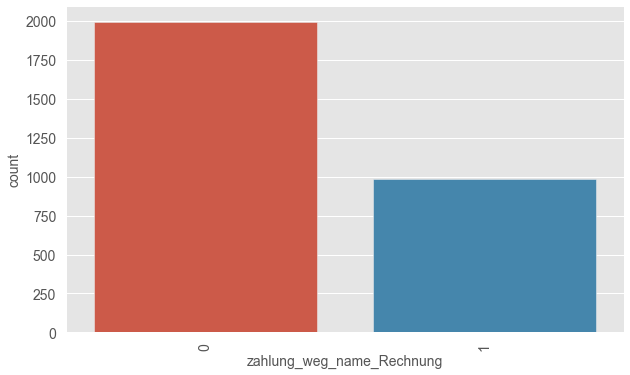

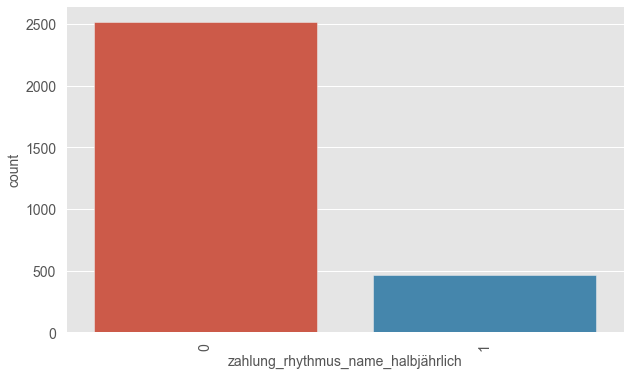

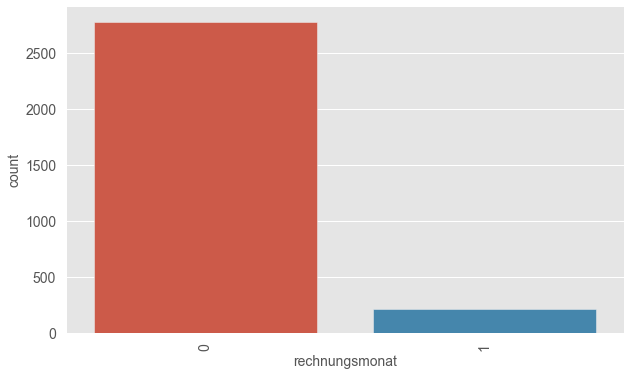

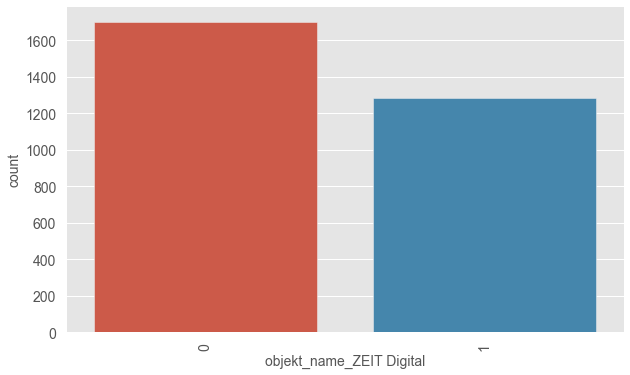

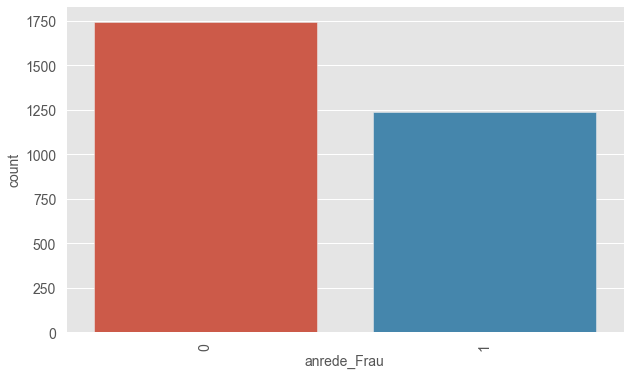

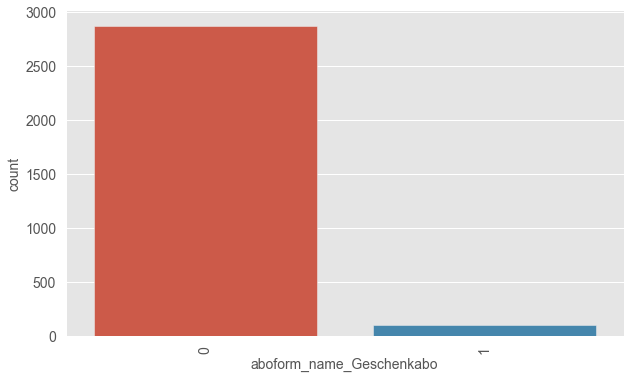

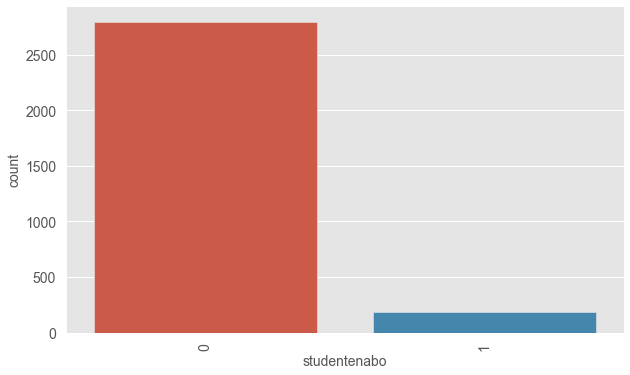

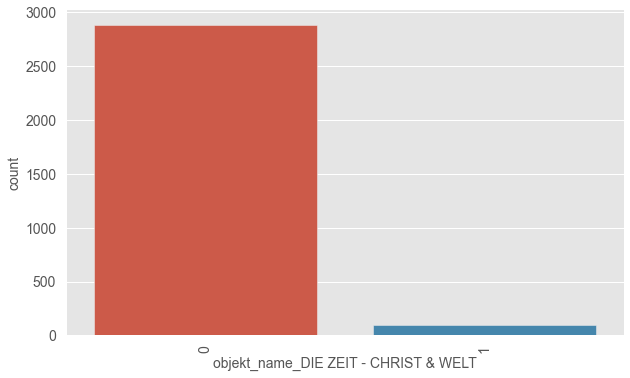

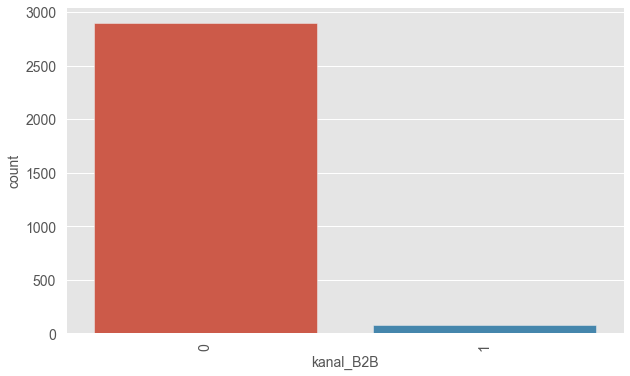

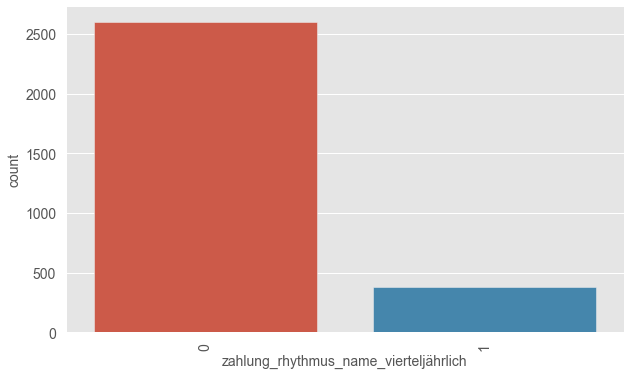

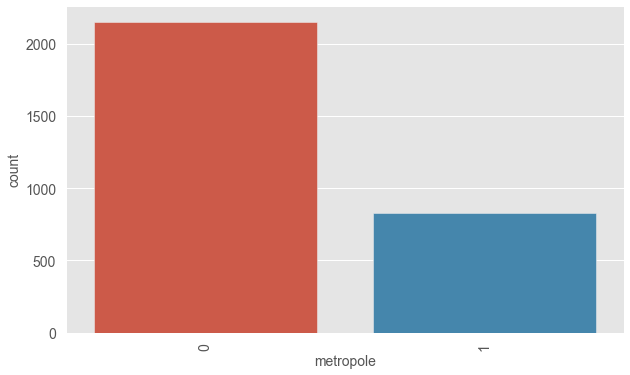

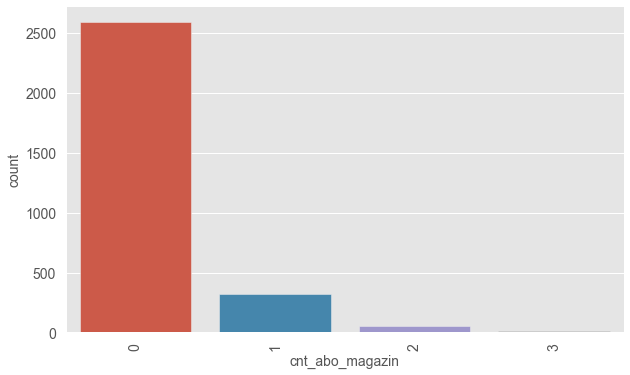

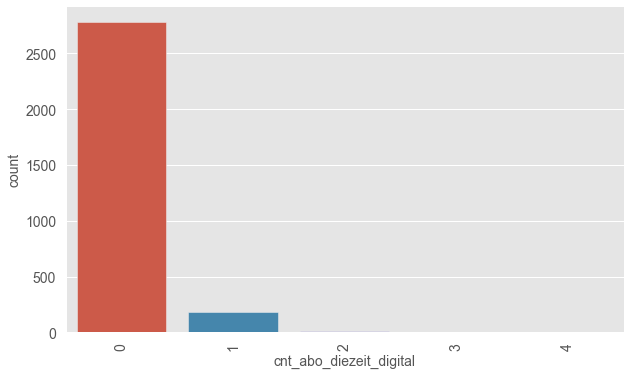

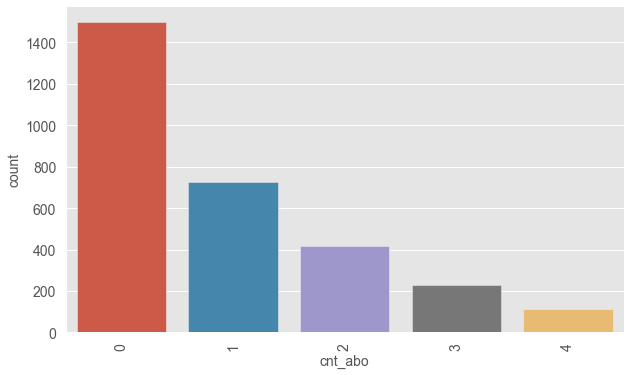

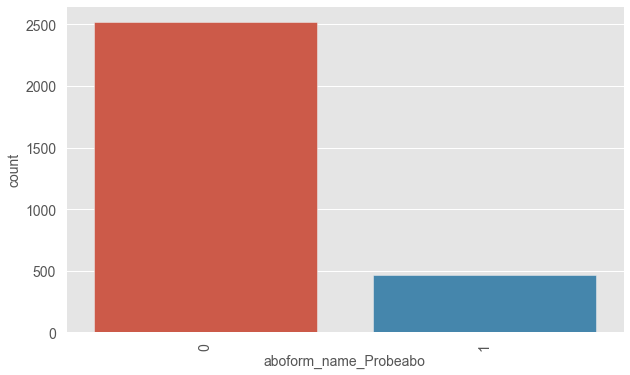

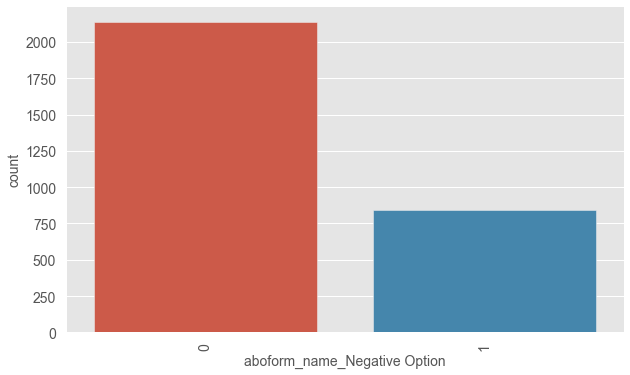

In [61]:
for i, f in enumerate(['zahlung_weg_name_Rechnung','zahlung_rhythmus_name_halbjährlich','rechnungsmonat', 'objekt_name_ZEIT Digital','anrede_Frau',
 'aboform_name_Geschenkabo','studentenabo','objekt_name_DIE ZEIT - CHRIST & WELT','kanal_B2B','zahlung_rhythmus_name_vierteljährlich',
 'metropole','cnt_abo_magazin', 'cnt_abo_diezeit_digital', 'cnt_abo','aboform_name_Probeabo', 'aboform_name_Negative Option']):
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=f, data=df_FN_vot)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

__Conclusion:__ We can observe similar patterns as in the EDA Notebook when observing the False Negatives of our best Models. This leads us to the conclusion that to be ables to obtain better results new Data and new features should be introduced to the Dataframe. 